# Classifying galaxies and quasars in the SDSS catalogue

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?



In [134]:
import numpy as np
import matplotlib.pyplot as plt

In [123]:
names = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', names=True, usecols=(0,1,2,3,4,6), dtype=float, comments='#')
names = names.dtype.names
data = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6),dtype=float,comments='#')
l = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=5, dtype=str)

In [124]:
d = dict(zip(names, data.T))

In [126]:
sub_colors = ['ug', 'gr', 'ri', 'iz']
for n in sub_colors:
    d[n] = d[n[0]] - d[n[1]]

labels = []
for i in range(len(l)):
    if l[i] == 'QSO': 
        labels.append(1)
    else: labels.append(0)
        
d['lab'] = labels

In [127]:
d

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238]),
 'ug': array([0.43537, 1.76946, 1.73268, ..., 1.31842, 1.27429, 1.05021]),
 'gr': array([-0.04604,  0.99829,  0.78703, ...,  0.43505,  0.6561 ,  0.35251]),
 'ri': array([0.23344, 0.43345, 0.33238, ..., 0.24972, 0.40154, 0.1885 ]),
 'iz': array([0.05721, 0.35621, 0.19199, ..., 0.20103, 0.186  , 0.09355]),
 'lab': [1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [128]:
X = np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = np.array([d['lab']]).T

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)
y_train = y_train.ravel()
y_val = y_val.ravel()
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(35000, 4) (15000, 4) (35000,) (15000,)


## Gaussian Naive Bayes

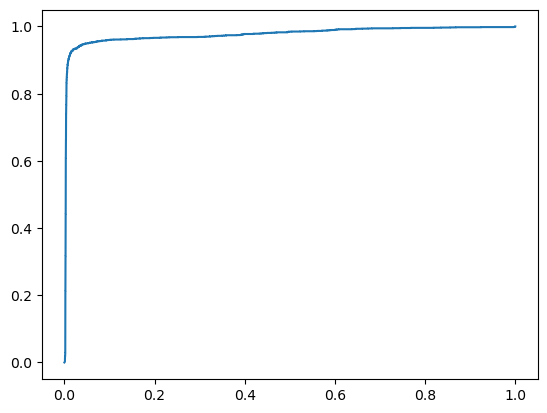

In [206]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_prob = gnb.predict_proba(X_val)
fpr, tpr, thresh = roc_curve(y_val, gnb_prob[:,1])
plt.plot(fpr, tpr)

Let's fit model using subsets of colors and let's see which one works best.

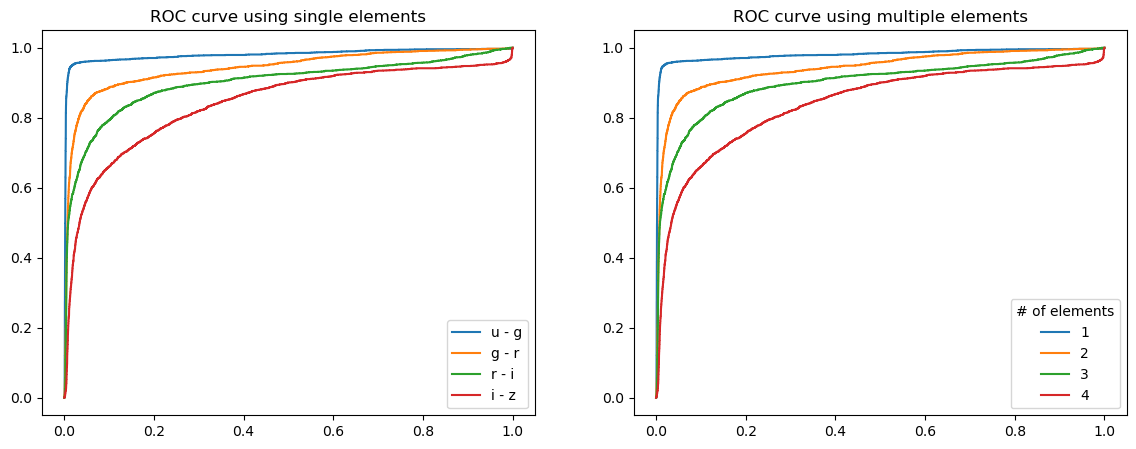

In [160]:
fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
for i in range(4):
    gnb.fit(X_train[:, i][:, None], y_train)
    gnb_prob = gnb.predict_proba(X_val[:, i][:, None])[:,1]
    fpr, tpr, thresh = roc_curve(y_val, gnb_prob)
    ax.plot(fpr, tpr, label = sub_colors[i][0] + ' - ' + sub_colors[i][1])
ax.set(title = 'ROC curve using single elements')
plt.legend()

ax = fig.add_subplot(122)
for i in range(4):
    gnb.fit(X_train[:, 0+i][:, None], y_train)
    gnb_prob = gnb.predict_proba(X_val[:, 0+i][:, None])[:,1]
    fpr, tpr, thresh = roc_curve(y_val, gnb_prob)
    ax.plot(fpr, tpr, label = i+1)
ax.set(title = 'ROC curve using multiple elements')

plt.legend(title = '# of elements')
plt.show()

Both plots seem to indicate that we can analyse the system using only the u - g line.

## Linear Discriminant Analysis

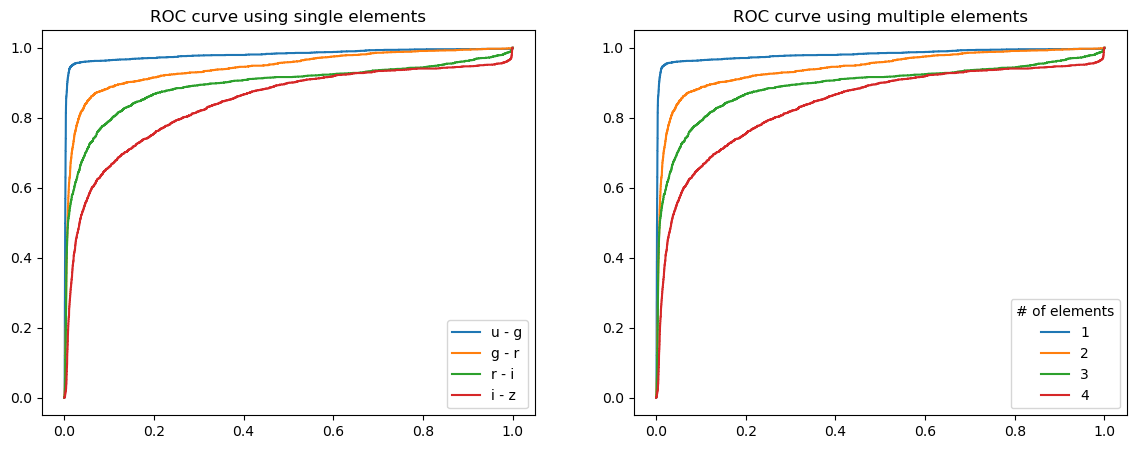

In [215]:
lda = LDA()
fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
for i in range(4):
    lda.fit(X_train[:, i][:, None], y_train)
    lda_prob = lda.predict_proba(X_val[:, i][:, None])[:, 1]
    fpr, tpr, thresh = roc_curve(y_val, lda_prob)
    ax.plot(fpr, tpr, label = sub_colors[i][0] + ' - ' + sub_colors[i][1])
ax.set(title = 'ROC curve using single elements')
plt.legend()

ax = fig.add_subplot(122)
for i in range(4):
    lda.fit(X_train[:, 0+i][:, None], y_train)
    lda_prob = lda.predict_proba(X_val[:, 0+i][:, None])[:,1]
    fpr, tpr, thresh = roc_curve(y_val, lda_prob)
    ax.plot(fpr, tpr, label = i+1)
ax.set(title = 'ROC curve using multiple elements')

plt.legend(title = '# of elements')
plt.show()

## Quadraric Discriminant Analysis

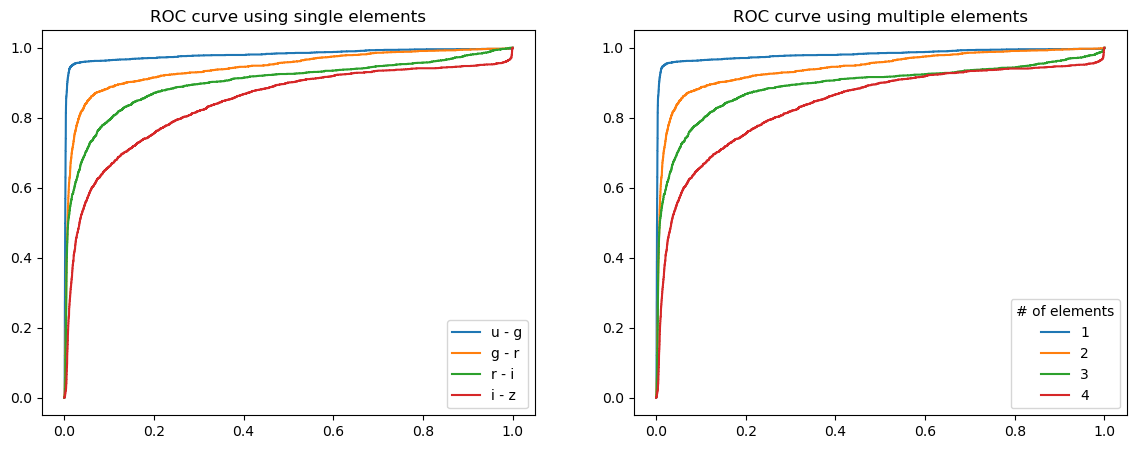

In [216]:
qda = QDA()
fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
for i in range(4):
    qda.fit(X_train[:, i][:, None], y_train)
    qda_prob = qda.predict_proba(X_val[:, i][:, None])[:, 1]
    fpr, tpr, thresh = roc_curve(y_val, qda_prob)
    ax.plot(fpr, tpr, label = sub_colors[i][0] + ' - ' + sub_colors[i][1])
ax.set(title = 'ROC curve using single elements')
plt.legend()

ax = fig.add_subplot(122)
for i in range(4):
    qda.fit(X_train[:, 0+i][:, None], y_train)
    qda_prob = lda.predict_proba(X_val[:, 0+i][:, None])[:,1]
    fpr, tpr, thresh = roc_curve(y_val, qda_prob)
    ax.plot(fpr, tpr, label = i+1)
ax.set(title = 'ROC curve using multiple elements')

plt.legend(title = '# of elements')
plt.show()